In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV #, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
X_pre = stroke.drop(['stroke', 'id'], axis=1)

y_pre = stroke['stroke'].values

In [4]:
numerical_features = X_pre.select_dtypes(include=np.number).columns
categorical_features = X_pre.select_dtypes(exclude=np.number).columns

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')
Categorical features: Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


devo fare un analisi delle features per verificare se esiste qualche outliers

In [5]:
def print_features_bar(X, feature, y, type='numerical'):
    fig, ax = plt.subplots(figsize=(12, 4))
    
    temp = X.copy()
    temp['y'] = y
    temp['bin'] = temp[feature] // 5 * 5 if temp[feature].nunique() > 20 and type=='numerical' else temp[feature]
    
    grouped = temp.groupby('bin').agg(
        count = ('y', 'size'),
        perc_y1 = ('y', lambda x: 100 * (x.sum() / len(x)))
    ).sort_index()
    
    cmap = plt.cm.Reds
    normed = grouped['perc_y1'] / grouped['perc_y1'].max()
    colors = cmap(normed)
    
    bars = ax.bar(range(len(grouped)), grouped['count'], color=colors)
    
    ax.set_title(f'Feature: {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    
    labels = [
        f"{label} ({count}; {perc:.0f}%)" 
        for label, count, perc in zip(grouped.index, grouped['count'], grouped['perc_y1'])
    ]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, grouped['perc_y1'].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('% di ictus (y=1)')
    
    plt.show()

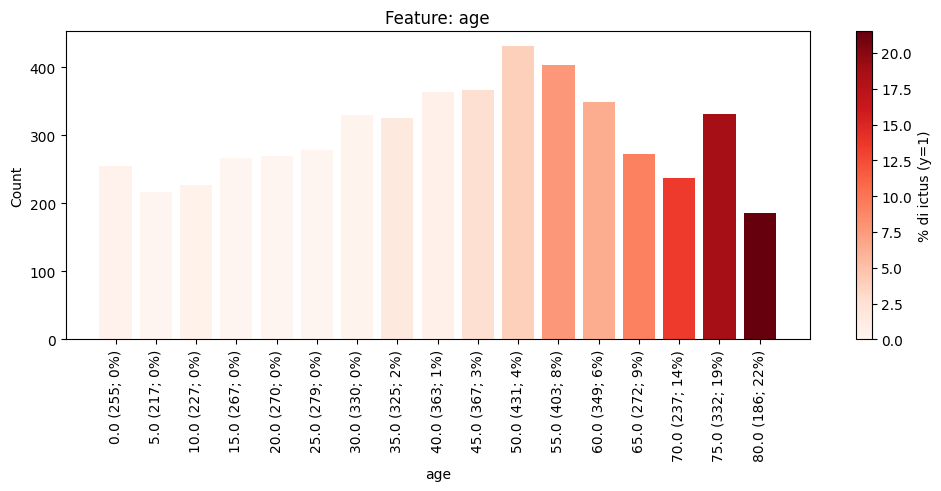

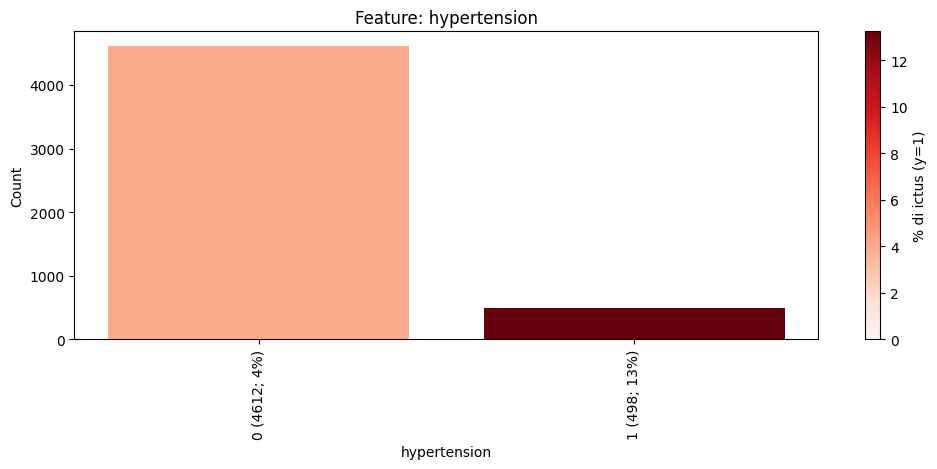

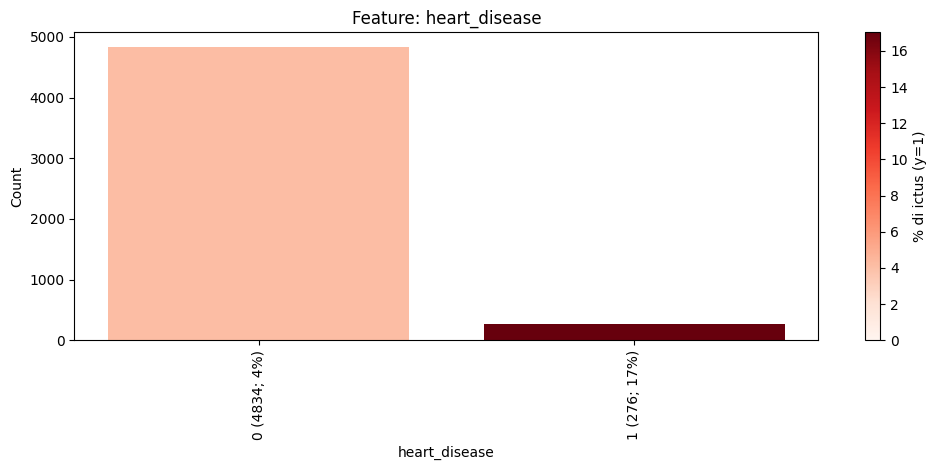

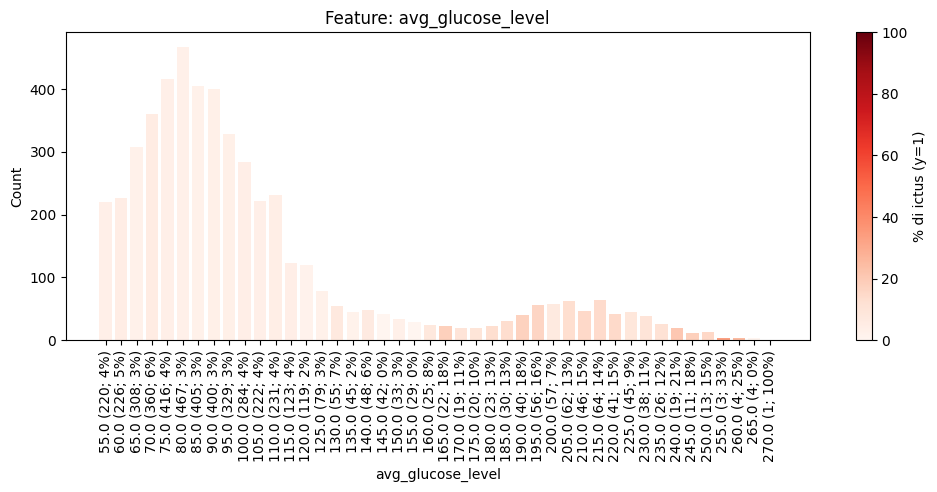

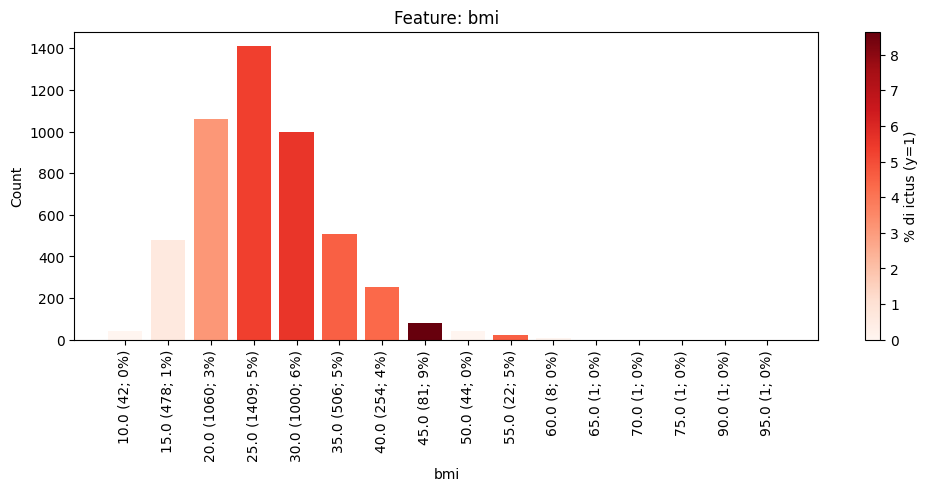

In [6]:
for feature in numerical_features:
    print_features_bar(X_pre, feature, y_pre)

dai dati disponibili una strategia interessante potrebbe essere:
* eliminare le righe di bmi sopra 60 e sotto gli 15
* eliminare ogni riga fino ai 35 anni perchè non sono significativi

In [7]:
stroke_age_cleaned = stroke[stroke['age'] > 35].copy()
stroke_bmi_cleaned = stroke_age_cleaned[stroke_age_cleaned['bmi'].between(15, 60)].copy()

stroke_bmi_cleaned.shape

(3047, 12)

In [8]:
X_elaborated = stroke_bmi_cleaned.drop(['stroke', 'id'], axis=1)

y_elaborated = stroke_bmi_cleaned['stroke'].values

In [9]:
nr_ictus = (y_elaborated == 1).sum()
total_cases = y_elaborated.shape[0]
nr_ictus/total_cases

np.float64(0.06793567443386939)

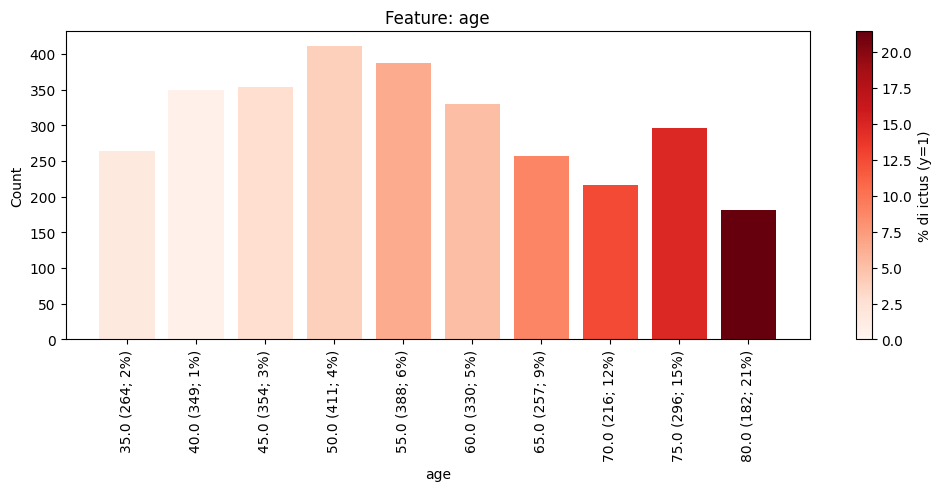

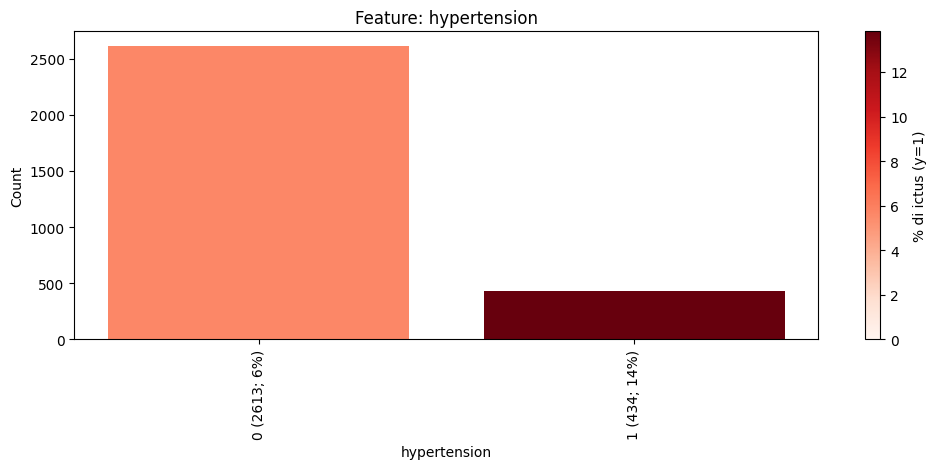

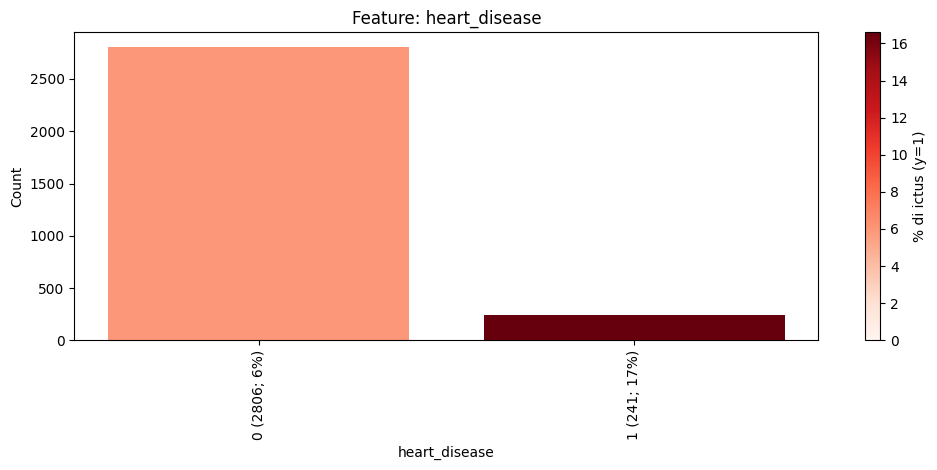

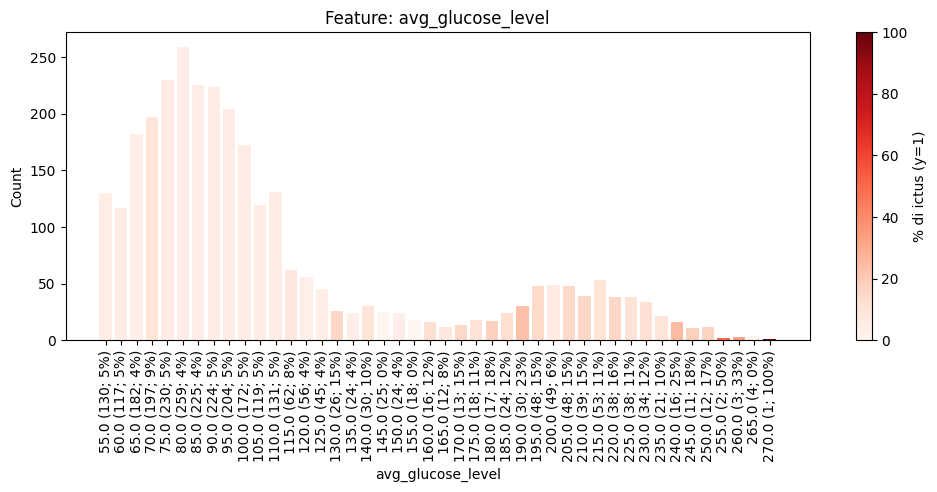

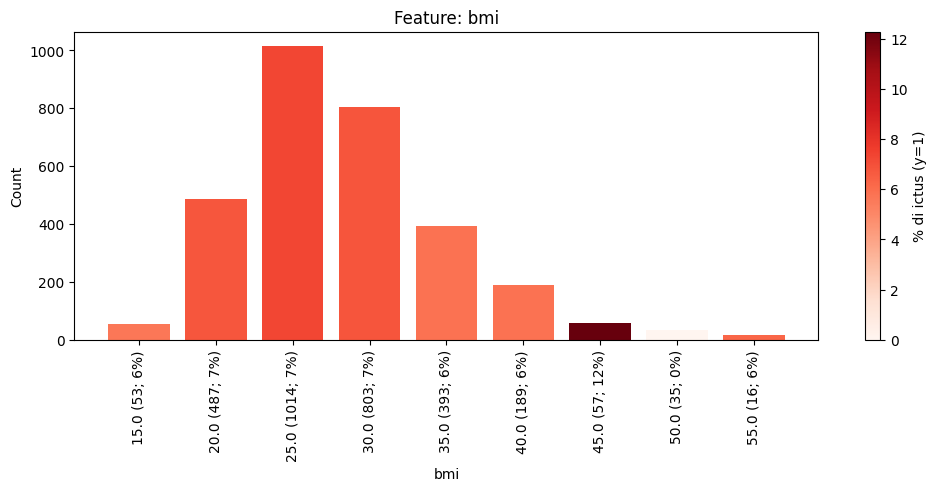

In [10]:
for feature in numerical_features:
    print_features_bar(X_elaborated, feature, y_elaborated)

si nota un maggior rischio di ictus nei casi il cui ci sono ipertensione o problemi legati al cuore, stranamente il rischio di ictus è alto in chi ha un bmi di 45 m non sembra essere presente al di sopra

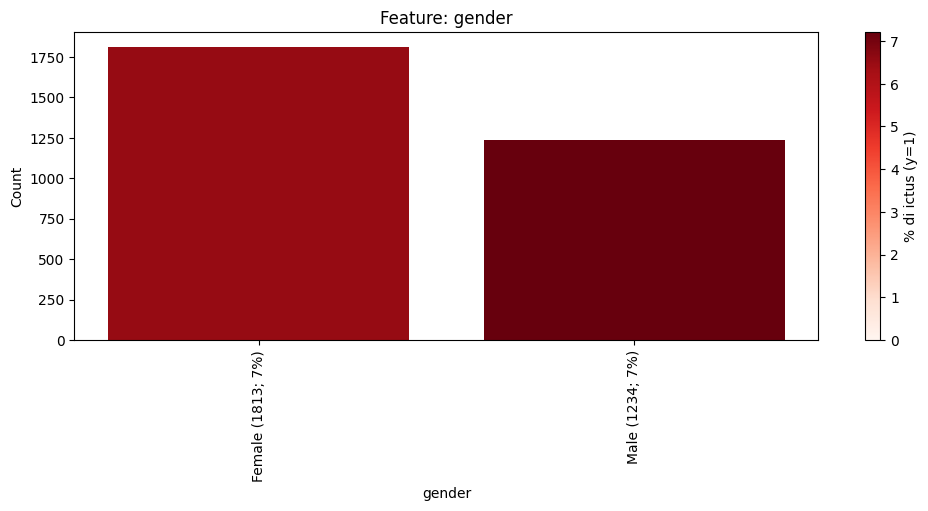

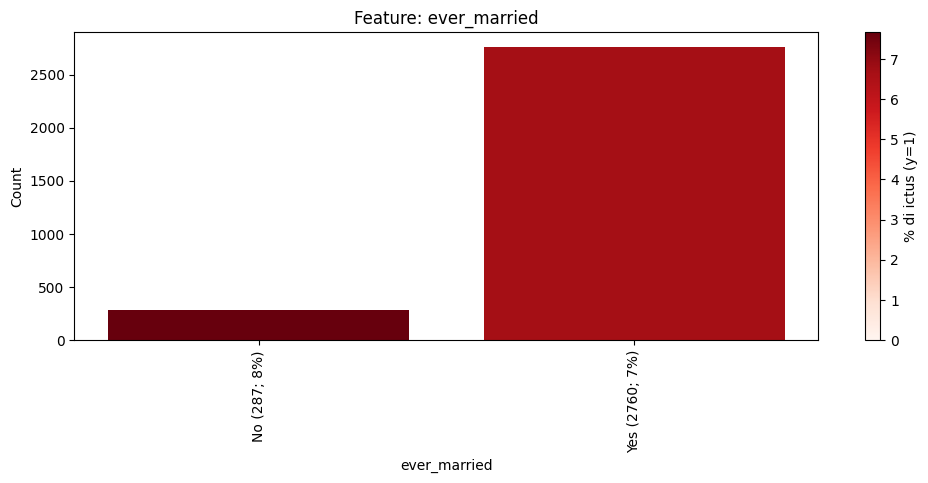

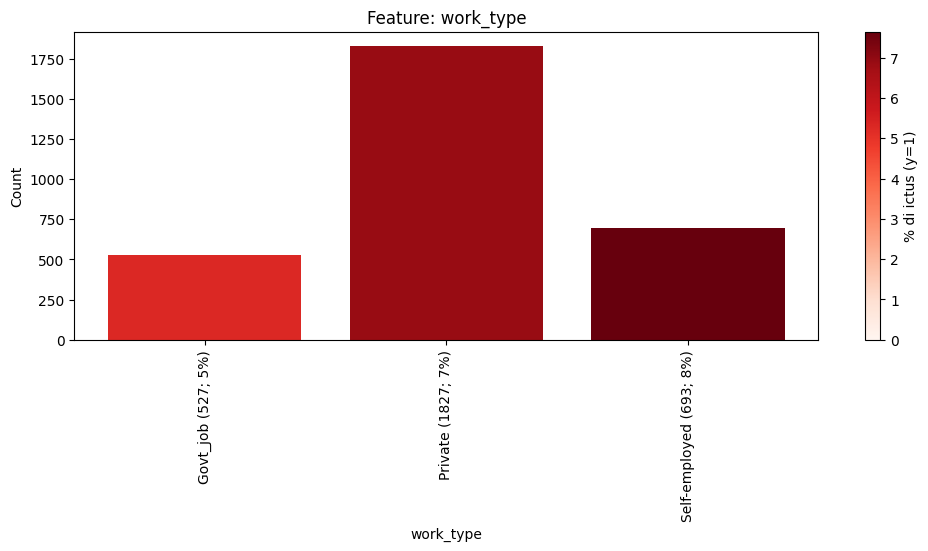

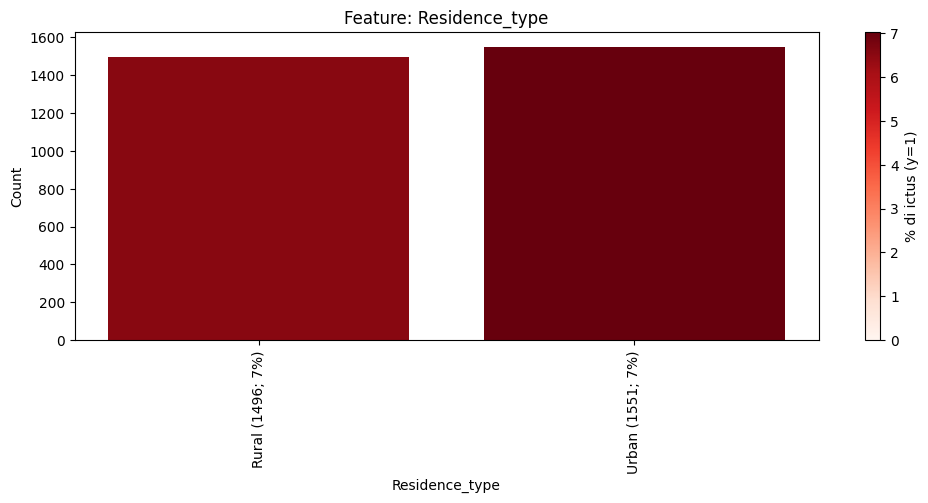

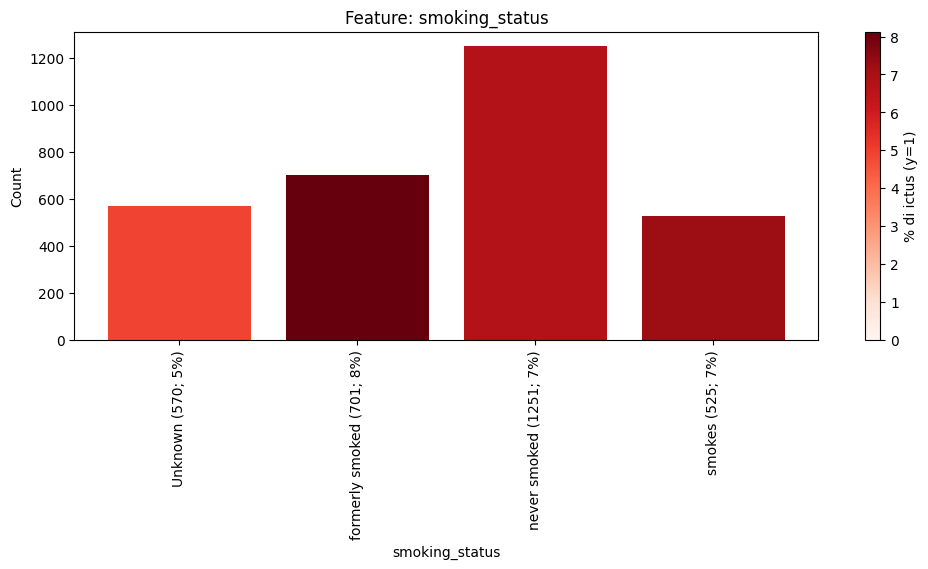

In [11]:
for feature in categorical_features:
    print_features_bar(X_elaborated, feature, y_elaborated, type='categorical')

Sopra ai 35 anni la situazione è la seguente:

* Rischio di ictus è lo stesso tra maschi e femmine (7%)
* Chi non è sposato sembra essere leggermente più a rischio rispetto a chi è sposato (ever_married: yes 7%, no 8%)
* I lavoratori governativi sembrano avere un basso rischio di ictus (5%) mentre autonomi e privati siano lievemente piu a rischio (8% e 7%)
* Il tipo di residenza non sembra esporre ad alcun rischio (7%)
* Ci sono differenze minime tra chi ha fumato, chi sta fumando e chi non ha mai fumato (unknows 5%, formerly smoked 8%, never smoked 7% e smokes 7%)

Di conseguenza passo a rimuovere il gender e il residence type

In [12]:
X_cleaned = X_elaborated.drop(['Residence_type', 'gender'], axis=1)

X_cleaned

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked
2,80.0,0,1,Yes,Private,105.92,32.5,never smoked
3,49.0,0,0,Yes,Private,171.23,34.4,smokes
4,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked
5,81.0,0,0,Yes,Private,186.21,29.0,formerly smoked
...,...,...,...,...,...,...,...,...
5101,45.0,0,0,Yes,Private,97.95,24.5,Unknown
5102,57.0,0,0,Yes,Private,77.93,21.7,never smoked
5106,81.0,0,0,Yes,Self-employed,125.20,40.0,never smoked
5108,51.0,0,0,Yes,Private,166.29,25.6,formerly smoked


In [13]:
X_cleaned

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked
2,80.0,0,1,Yes,Private,105.92,32.5,never smoked
3,49.0,0,0,Yes,Private,171.23,34.4,smokes
4,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked
5,81.0,0,0,Yes,Private,186.21,29.0,formerly smoked
...,...,...,...,...,...,...,...,...
5101,45.0,0,0,Yes,Private,97.95,24.5,Unknown
5102,57.0,0,0,Yes,Private,77.93,21.7,never smoked
5106,81.0,0,0,Yes,Self-employed,125.20,40.0,never smoked
5108,51.0,0,0,Yes,Private,166.29,25.6,formerly smoked


In [14]:
y_cleaned = y_elaborated.copy()

di seguito passo alla gestione di variabili numeriche e categoriche

In [15]:
cleaned_numerical_features = X_cleaned.select_dtypes(include=np.number).columns
cleaned_categorical_features = X_cleaned.select_dtypes(exclude=np.number).columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, cleaned_numerical_features),
    ('cat', categorical_transformer, cleaned_categorical_features)
  ])

pipeline_preprocessing = SKPipeline(steps=[
  ('preprocessor', preprocessor_with_imputation),
])


uso il 2% come train di test e faccio il preprocessin sui dati di train

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=0)

In [17]:
X_preprocessed = pipeline_preprocessing.fit_transform(X_train)

creo una pipeline prima per fare il kernel pca, quindi per addestrare un xgboot classifier in un sistema più semplice e lineare

In [ ]:
ratio = sum(y_train == 0) / sum(y_train == 1)

kpca_pipe = SKPipeline(
  steps=[
    ('kernelpca', KernelPCA(random_state=0)),
    ('xgboost', XGBClassifier(random_state=0, scale_pos_weight=ratio))
])

In [ ]:
param_grid = [
    {
        'kernelpca__n_components': [2, 3, 4, 5, 6],
        'kernelpca__kernel': ['linear', 'rbf'],
        'kernelpca__gamma': [0.1, 0.5, 1.0, 2.0],
        
        'xgboost__n_estimators': [100, 200],
        'xgboost__learning_rate': [0.01, 0.1],
        'xgboost__max_depth': [3, 5]
    }, 
    {
        'kernelpca__n_components': [2, 3, 4, 5, 6],
        'kernelpca__kernel': ['poly'],
        'kernelpca__degree': [2, 3, 4],
        'kernelpca__coef0': [0.0, 0.5, 1.0],
        
        'xgboost__n_estimators': [100, 200],
        'xgboost__learning_rate': [0.01, 0.1],
        'xgboost__max_depth': [3, 5]
    }
]

imposto la mia gridsearch su k fold stratificati

In [21]:
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [22]:
gs = GridSearchCV(kpca_pipe, param_grid=param_grid, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=3) # random_state=0, n_iter=20
gs.fit(X_preprocessed, y_train)

Fitting 3 folds for each of 680 candidates, totalling 2040 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('kernelpca', KernelPCA(random_state=0)),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=...
                          'xgboost__learning_rate': [0.01, 0.1],
                          'xgboost__max_depth': [3, 5],
                          'xgboost__n_estimators': [100, 200]},
                         {'kernelpca__coef0': [0.0, 0.5, 1.0],
                          'kernelpca__degree': [2, 3, 4],
                          'kernelpca__kernel': ['poly'],
                          'kernelpca__n_components': [2, 3, 4, 5, 6],
                          'xgboost__learning_rate': [0.01, 0.1],
                          'xgboost__max_depth': [3, 5],
                          'xgboost__n_estimators': [100, 200]}],
             scoring='roc_auc', verbose=3)

In [23]:
gs.best_params_

{'kernelpca__gamma': 0.1,
 'kernelpca__kernel': 'rbf',
 'kernelpca__n_components': 2,
 'xgboost__learning_rate': 0.01,
 'xgboost__max_depth': 3,
 'xgboost__n_estimators': 200}

In [24]:
gs.best_score_

np.float64(0.7447365689516666)

In [25]:
best_estimator = gs.best_estimator_

trovato il miglior estimatore passo alla valutazione

In [31]:
# visualmente non è possibile trovare dimensioni che distanzino le classi in modo chiaro

# for i in range(0, 5):
#     for j in range(i + 1, 6):
#         plt.figure(figsize=(10, 6))
#         plt.scatter(X_preprocessed[:, j], X_preprocessed[:, i], c=y_train, cmap='coolwarm', edgecolor='k', s=20)
#         plt.title(f'Kernel PCA Component {i+1} vs Component {j+1}')

In [27]:
def evaluate_predictions(predictions, y_true):
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc = roc_auc_score(y_true, predictions)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()

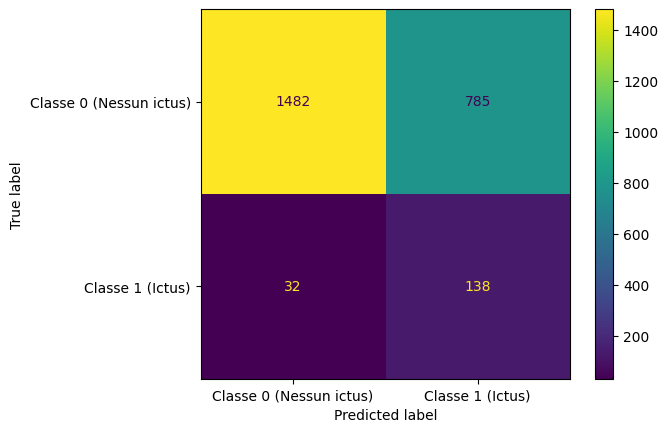

Percentuale di veri negativi: 65.37%
Percentuale di veri positivi: 81.18%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.98      0.65      0.78      2267
       Classe 1 (Ictus)       0.15      0.81      0.25       170

               accuracy                           0.66      2437
              macro avg       0.56      0.73      0.52      2437
           weighted avg       0.92      0.66      0.75      2437

[[1482  785]
 [  32  138]]


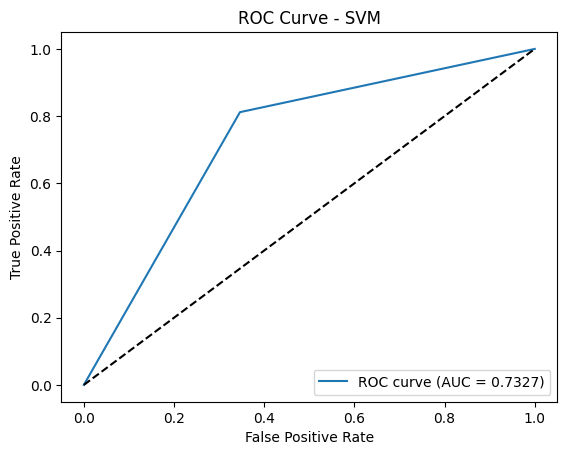

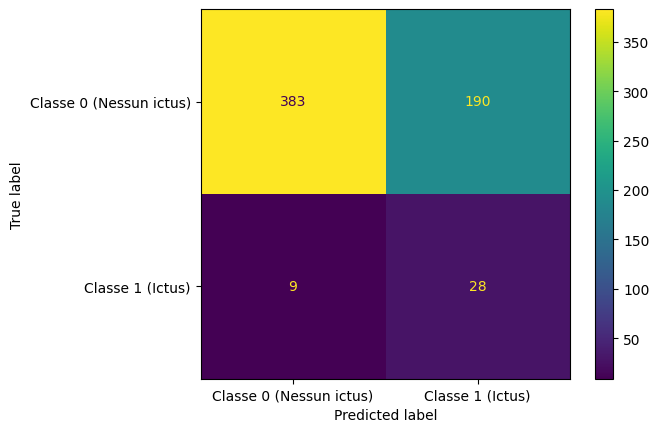

Percentuale di veri negativi: 66.84%
Percentuale di veri positivi: 75.68%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.98      0.67      0.79       573
       Classe 1 (Ictus)       0.13      0.76      0.22        37

               accuracy                           0.67       610
              macro avg       0.55      0.71      0.51       610
           weighted avg       0.93      0.67      0.76       610

[[383 190]
 [  9  28]]


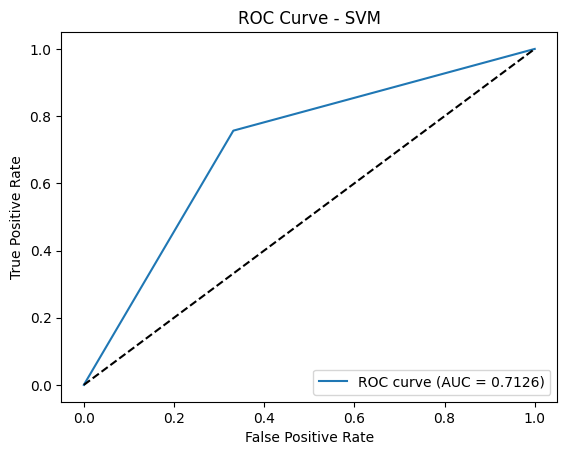

In [28]:
evaluate_predictions(best_estimator.predict(X_preprocessed), y_train)
X_test_preprocessed = pipeline_preprocessing.transform(X_test)
evaluate_predictions(best_estimator.predict(X_test_preprocessed), y_test)

pur non avendo avuto prestazioni eccezionali il modello ha una buona recall, questo potrebbe essere il punto di inizio verso una nuova analisi, magari creando diversi modelli che valutano il caso in base alla fascia di età